In [1]:
#@title
# initialization - step 1

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
#@title
# initialization - step 2

!mkdir -p drive
!google-drive-ocamlfuse drive

# Bắt đầu ở đây nè ahihi

Đây là bắt đầu quá trình gian khổ của việc train. Code dưới do anh Đăng Chính viết, thật tuyệt vời! 

## Bước đầu tiên: Preprocess data

Đây là code để resize ảnh và chia ảnh thành từng block 64x64

In [0]:
import cv2
import os
import numpy as np

In [0]:
block_width=64
block_height=64

def resize(path,block_width,block_height):
    list_img=[]
    for file in os.listdir(path):
        img = cv2.imread(path + file)
        img_height = int((img.shape[0]/block_height+1)*block_height)
        img_width = int((img.shape[1]/block_width+1)*block_width)
        img = cv2.resize(img, (img_width,img_height))
        list_img.append(img)
    return list_img

# list_img = resize('data/',block_width,block_height)
# print(list_img[4])

In [17]:
def blockdivide(list,block_width,block_height):
    list_block=[]
    for img in list:
        for i in range(int(img.shape[0]/block_height)):
            for j in range(int(img.shape[1]/block_width)):
                block = img[
                    i*block_height:i*block_height + block_height,
                    j*block_width:j*block_width + block_width]
                list_block.append(block)
        print(int(img.shape[0]/block_height))
        print(int(img.shape[1]/block_height))
    list_block = np.array(list_block)
    return list_block

list_img = resize('drive/GGLandmark/data/',block_width,block_height)
list_block = blockdivide(list_img,block_width,block_height)
print (list_block.shape)

51
67
5
5
3
3
19
26
19
26
19
26
19
26
11
17
10
13
(5744, 64, 64, 3)


## Bước thứ hai: Train AutoEncoder

Code này cũng do anh Chính viết và lấy architecture của anh ý để train :D 

In [10]:
from keras.layers import Input,  Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model,load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
def build(old_phase=None, pref_len = None, suf_len = None):
  input = Input((64,64,3), name = 'input')
  
  model = input
  #encoder
  n_filters = [256,128,64]
  for n_filter in n_filters:
    model = Conv2D(
      filters = n_filter,
      kernel_size =(3,3),
      strides =(1,1),
      padding = "same",
      activation = 'relu'
    )(model)
    model = MaxPooling2D(
      pool_size = (2,2)
    )(model)
  
  #code
  encoded = Conv2D(
    filters =4,
    kernel_size = (3,3),
    strides = (1,1),
    padding = 'same',
    activation = 'relu',
    name = 'encoded'
  )(model)
  
  model = encoded
  
  #decoder
  n_filters = [64,128,256]
  for n_filter in n_filters:
    model = Conv2D(
      filters = n_filter,
      kernel_size =(3,3),
      strides =(1,1),
      padding = "same",
      activation = 'relu'
    )(model)
    model = UpSampling2D(
      size = (2,2)
    )(model)
  
  #decoded image
  decoded = Conv2D(
    filters=3,
    kernel_size=(3,3),
    strides = (1,1),
    padding='same',
    activation='sigmoid',
    name = 'decoded'
  )(model)
  
  model = Model(input, decoded)
  
  #load old phase
  if old_phase is not None:
    old_build = load_model(old_phase)
    weights = []
    for layer in old_build.layers:
      weights.append(layer.get_weights())
      
    n_layers = len(model.layers)
    for i in range(pref_len):
      model.layers[i].set_weights(weights[i])
      model.layers[i].trainable = False
    
    for i in range(suf_len):
      model.layers[-1-i].set_weights(weights[-1-i])
      model.layers[-1-i].trainable = False
      
      
  model.compile(loss = 'mean_squared_error', optimizer = 'adam')
  print(model.summary())
  
  return model

In [15]:
model = build('drive/saved.h5', pref_len =5, suf_len =4)

OSError: ignored

Sau khi train xong mỗi phase thì phải lưu lại, đây chính là nó!

In [31]:
from keras.callbacks import ModelCheckpoint

model = load_model('drive/saved.h5')

filepath = 'drive/Save_data/saved.h5'
save_model = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

model.fit(
    x = list_block/255.0, 
    y = list_block/255.0, 
    batch_size=64, 
    epochs=100,
    validation_split=0.2,
    callbacks=[save_model]
)

Train on 4595 samples, validate on 1149 samples
Epoch 1/100
4595/4595 [==============================] - 12s 3ms/step - loss: 6.3534e-04 - val_loss: 0.0030
Epoch 2/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.2388e-04 - val_loss: 0.0029
Epoch 3/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.3727e-04 - val_loss: 0.0030
Epoch 4/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1791e-04 - val_loss: 0.0030
Epoch 5/100
1728/4595 [==========>...................] - ETA: 5s - loss: 6.6993e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 6.3167e-04 - val_loss: 0.0029
Epoch 6/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1736e-04 - val_loss: 0.0030
Epoch 7/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1853e-04 - val_loss: 0.0029
Epoch 8/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.2931e-04 - val_loss: 0.0029
Epoch 9/100
4352/4595 [===========================>..] - ETA: 0s - loss: 6.1500e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 6.1232e-04 - val_loss: 0.0029
Epoch 10/100
4595/4595 [==============================] - 10s 2ms/step - loss: 7.1455e-04 - val_loss: 0.0030
Epoch 11/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.2456e-04 - val_loss: 0.0029
Epoch 12/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1120e-04 - val_loss: 0.0029
Epoch 13/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.0626e-04 - val_loss: 0.0029


Epoch 14/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.0927e-04 - val_loss: 0.0029
Epoch 15/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.2004e-04 - val_loss: 0.0029
Epoch 16/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1945e-04 - val_loss: 0.0029
Epoch 17/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1138e-04 - val_loss: 0.0029
Epoch 18/100
3520/4595 [=====================>........] - ETA: 1s - loss: 6.0703e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 6.0425e-04 - val_loss: 0.0030
Epoch 19/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1531e-04 - val_loss: 0.0030
Epoch 20/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.0978e-04 - val_loss: 0.0029
Epoch 21/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.0266e-04 - val_loss: 0.0029
Epoch 22/100
4544/4595 [============================>.] - ETA: 0s - loss: 6.1238e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 6.1149e-04 - val_loss: 0.0029
Epoch 23/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.0251e-04 - val_loss: 0.0029
Epoch 24/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.9809e-04 - val_loss: 0.0029
Epoch 25/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.9604e-04 - val_loss: 0.0030
Epoch 26/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1484e-04 - val_loss: 0.0029
Epoch 27/100
  64/4595 [..............................] - ETA: 8s - loss: 3.9873e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 5.9824e-04 - val_loss: 0.0029
Epoch 28/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1313e-04 - val_loss: 0.0030
Epoch 29/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.9251e-04 - val_loss: 0.0029
Epoch 30/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.9410e-04 - val_loss: 0.0029
Epoch 31/100
4032/4595 [=========================>....] - ETA: 1s - loss: 6.1334e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 6.1075e-04 - val_loss: 0.0029
Epoch 32/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.0585e-04 - val_loss: 0.0029
Epoch 33/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.0650e-04 - val_loss: 0.0029
Epoch 34/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.8364e-04 - val_loss: 0.0029
Epoch 35/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.8493e-04 - val_loss: 0.0029


Epoch 36/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.9451e-04 - val_loss: 0.0029
Epoch 37/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.0301e-04 - val_loss: 0.0030
Epoch 38/100
4595/4595 [==============================] - 10s 2ms/step - loss: 6.1203e-04 - val_loss: 0.0029
Epoch 39/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.8242e-04 - val_loss: 0.0029
Epoch 40/100
3520/4595 [=====================>........] - ETA: 1s - loss: 6.0949e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 5.9967e-04 - val_loss: 0.0029
Epoch 41/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.7196e-04 - val_loss: 0.0028
Epoch 42/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.9578e-04 - val_loss: 0.0028
Epoch 43/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.7400e-04 - val_loss: 0.0028
Epoch 44/100
4544/4595 [============================>.] - ETA: 0s - loss: 5.9130e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 5.8854e-04 - val_loss: 0.0029
Epoch 45/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.8008e-04 - val_loss: 0.0029
Epoch 46/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.8182e-04 - val_loss: 0.0028
Epoch 47/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.5868e-04 - val_loss: 0.0028
Epoch 48/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.5418e-04 - val_loss: 0.0027
Epoch 49/100
  64/4595 [..............................] - ETA: 8s - loss: 5.8807e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 5.5065e-04 - val_loss: 0.0027
Epoch 50/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.4742e-04 - val_loss: 0.0027
Epoch 51/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.2548e-04 - val_loss: 0.0027
Epoch 52/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.3346e-04 - val_loss: 0.0028
Epoch 53/100
4032/4595 [=========================>....] - ETA: 1s - loss: 5.6459e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 5.8204e-04 - val_loss: 0.0028
Epoch 54/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.3068e-04 - val_loss: 0.0027
Epoch 55/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.1948e-04 - val_loss: 0.0026
Epoch 56/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.0717e-04 - val_loss: 0.0026
Epoch 57/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.0888e-04 - val_loss: 0.0026


Epoch 58/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.9738e-04 - val_loss: 0.0026
Epoch 59/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.8617e-04 - val_loss: 0.0026
Epoch 60/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.9489e-04 - val_loss: 0.0025
Epoch 61/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.9984e-04 - val_loss: 0.0025
Epoch 62/100
3520/4595 [=====================>........] - ETA: 1s - loss: 4.9508e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 4.7549e-04 - val_loss: 0.0025
Epoch 63/100
4595/4595 [==============================] - 10s 2ms/step - loss: 5.1002e-04 - val_loss: 0.0025
Epoch 64/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.7621e-04 - val_loss: 0.0025
Epoch 65/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.8761e-04 - val_loss: 0.0026
Epoch 66/100
4544/4595 [============================>.] - ETA: 0s - loss: 4.8390e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 4.8251e-04 - val_loss: 0.0025
Epoch 67/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.7390e-04 - val_loss: 0.0025
Epoch 68/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.6963e-04 - val_loss: 0.0025
Epoch 69/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.6114e-04 - val_loss: 0.0025
Epoch 70/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.7468e-04 - val_loss: 0.0025
Epoch 71/100
  64/4595 [..............................] - ETA: 7s - loss: 3.8773e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 4.6039e-04 - val_loss: 0.0025
Epoch 72/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.7174e-04 - val_loss: 0.0025
Epoch 73/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.6050e-04 - val_loss: 0.0025
Epoch 74/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.5866e-04 - val_loss: 0.0025
Epoch 75/100
4032/4595 [=========================>....] - ETA: 1s - loss: 4.5891e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 4.5812e-04 - val_loss: 0.0025
Epoch 76/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.7929e-04 - val_loss: 0.0025
Epoch 77/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.6720e-04 - val_loss: 0.0025
Epoch 78/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.5626e-04 - val_loss: 0.0024
Epoch 79/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.4764e-04 - val_loss: 0.0024


Epoch 80/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.9327e-04 - val_loss: 0.0025
Epoch 81/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.6359e-04 - val_loss: 0.0024
Epoch 82/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.4301e-04 - val_loss: 0.0025
Epoch 83/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.5197e-04 - val_loss: 0.0024
Epoch 84/100
3520/4595 [=====================>........] - ETA: 1s - loss: 4.5743e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 4.5106e-04 - val_loss: 0.0024
Epoch 85/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.5382e-04 - val_loss: 0.0026
Epoch 86/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.6428e-04 - val_loss: 0.0024
Epoch 87/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.3627e-04 - val_loss: 0.0024
Epoch 88/100
4544/4595 [============================>.] - ETA: 0s - loss: 4.4542e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 4.4635e-04 - val_loss: 0.0024
Epoch 89/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.4975e-04 - val_loss: 0.0024
Epoch 90/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.4437e-04 - val_loss: 0.0024
Epoch 91/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.4773e-04 - val_loss: 0.0024
Epoch 92/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.5735e-04 - val_loss: 0.0024
Epoch 93/100
  64/4595 [..............................] - ETA: 9s - loss: 2.7374e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 4.5512e-04 - val_loss: 0.0024
Epoch 94/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.3345e-04 - val_loss: 0.0024
Epoch 95/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.3513e-04 - val_loss: 0.0024
Epoch 96/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.4495e-04 - val_loss: 0.0024
Epoch 97/100
4032/4595 [=========================>....] - ETA: 1s - loss: 4.3560e-04

4595/4595 [==============================] - 10s 2ms/step - loss: 4.3070e-04 - val_loss: 0.0024
Epoch 98/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.5618e-04 - val_loss: 0.0025
Epoch 99/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.4285e-04 - val_loss: 0.0024
Epoch 100/100
4595/4595 [==============================] - 10s 2ms/step - loss: 4.4246e-04 - val_loss: 0.0024


Bước này là test data xem mình encode có ngáo không :D 

In [32]:
import matplotlib.pyplot as plt

In [36]:
test_model = load_model('drive/saved2.h5')

def visualize_test(img, model):
  pred = model.predict(np.expand_dims(img / 255.0, axis=0))[0]
  pred = (pred * 255.0).astype(np.uint8)
  
  fig, ax = plt.subplots(2, 1)
  ax[0].imshow(img)
  ax[1].imshow(pred)
  plt.show()

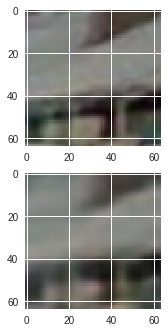

In [39]:
visualize_test(list_block[1465],test_model)

## Bước thứ 2.5: Bỏ đi decoder và chỉ lấy encoder

Cuối cùng mình cũng được làm gì đó! Đây là phần code của Linh, với sự trợ giúp của anh Giang.

In [46]:
model = load_model('drive/saved2.h5')
print(model.summary())
input = model.get_layer('input_7')
encoded = model.get_layer('encoded')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 256)       7168      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 64)          0         
__________

In [49]:
model = Model(input.input, encoded.output)

filepath_encoded = 'drive/Save_data/encoded.h5'
model.save(filepath_encoded)

Sau đó thì tạo hàm để encode ra một đống code cho dataset. Đây là bước trước bước bag of words.

In [0]:
# because Chinh's resize def has gone wrong, i put mine in 

def size(path, block_height, block_width):
  img = cv2.imread(path)
  img = cv2.resize(img, (int(img.shape[1]/block_width + 1)*block_width, int(img.shape[0]/block_height + 1)*block_height))
  return img

In [0]:
def blockdv(img, block_width, block_height):
  blocks=[]
  for i in range(int(img.shape[0]/block_height)):
    for j in range(int(img.shape[1]/block_width)):
      block = img[i*block_height:i*block_height + block_height, j*block_width:j*block_width + block_width]
      blocks.append(block)
  blocks = np.array(list_block)
  return blocks

In [0]:
def imgtocode(path, model_working, block_width, block_height):
  print(path)
  img = size(path, block_width, block_height)
  print(img.shape)
  block = blockdv(img, block_width, block_height)
  print(block.shape)
  model = model_working
  return model.predict(block)

Xin lỗi ạ đây là phần test cái code trên 

In [21]:
filepath_test = 'drive/GGLandmark/test data/'
print(os.listdir(filepath_test))

for file in os.listdir(filepath_test):
  code = imgtocode(filepath_test + file, model, 64, 64)
  #list_code = np.array(list_code)
  print(code.shape)

['339dfb46e4b2ff72.jpg', '3227cb2418122f20.jpg', 'f51ebe0ed44073f2.jpg', 'cb7e79a10e838d3b.jpg', '94bbe513de6ec272.jpg', '914005001af1f725.jpg', '3143f49f0b3b9310.jpg', '576b29445ebf8545.jpg', '64641fb426add28f.jpg', 'db84addaee671647.jpg', '4213700cbe4eb748.jpg', '95fb5e7e041459e8.jpg', '350ed2bd676bff59.jpg', 'c6265aba551291c7.jpg', 'e6c50a7999963663.jpg', '175736b32ea37e9c.jpg', '80b662ef299816d2.jpg', 'f497640b830c4cab.jpg', '051be7a51fef53d1.jpg', 'c01939fd373d2cd9.jpg', '4841acaff389f1ed.jpg', 'e62141eabe1b4712.jpg', '304a404a62c7430b.jpg', 'cf6c71122667a9dc.jpg', 'e0bc4c41973f2ef6.jpg', '24a0b82ab66b6958.jpg', '6fe6af24a08446cb.jpg', '2e7181dcc6bbc6fa.jpg']


NameError: ignored